<a href="https://colab.research.google.com/github/tylaar1/PICAR-autopilot/blob/main/BA_cleaned_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [28]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1) DATA PRE-PROCESSING

a) Load in labels + image file paths

b) combine them into one dataframe

c) EDA - spotted and removed erroneous label (speed = 1.42...)

## `cleaned_df` is the final df with all of this completed

### 1a) load in labels + image file paths

In [30]:
labels_file_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_norm.csv'
#labels_file_path = '/content/drive/MyDrive/0. MSc MLiS/google SPRING SEMESTER/1. PHYS4036 MLiS2/MLiS2 Project/KAGGLEDATAmachine-learning-in-science-ii-2025/training_norm.csv'
labels_df = pd.read_csv(labels_file_path, index_col='image_id')

In [31]:
#image_folder_path = '/content/drive/MyDrive/0. MSc MLiS/google SPRING SEMESTER/1. PHYS4036 MLiS2/MLiS2 Project/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data'
image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data'
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'

Checking labels dataframe

In [32]:
labels_df.head()

,angle,speed
image_id,,
1,0.4375,0.0
2,0.8125,1.0
3,0.4375,1.0
4,0.6250,1.0
5,0.5000,0.0


Checking image file paths dataframe - as you can see the file paths are ordered correctly (1.png, 2.png, 3.png, ...)

In [33]:
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/content/drive/MyDrive/machine-learning-in-sci...
2,/content/drive/MyDrive/machine-learning-in-sci...
3,/content/drive/MyDrive/machine-learning-in-sci...
4,/content/drive/MyDrive/machine-learning-in-sci...
5,/content/drive/MyDrive/machine-learning-in-sci...


### 1b) Combine labels and image file paths into one dataframe

In [34]:
merged_df = pd.merge(labels_df, imagefilepaths_df, on='image_id', how='inner')
merged_df['speed'] = merged_df['speed'].round(6) # to get rid of floating point errors

In [35]:
merged_df.head()

,angle,speed,image_file_paths
image_id,,,
1,0.4375,0.0,/content/drive/MyDrive/machine-learning-in-sci...
2,0.8125,1.0,/content/drive/MyDrive/machine-learning-in-sci...
3,0.4375,1.0,/content/drive/MyDrive/machine-learning-in-sci...
4,0.6250,1.0,/content/drive/MyDrive/machine-learning-in-sci...
5,0.5000,0.0,/content/drive/MyDrive/machine-learning-in-sci...


In [36]:
merged_df.loc[3139:3143]

,angle,speed,image_file_paths
image_id,,,
3139,0.750,1.0,/content/drive/MyDrive/machine-learning-in-sci...
3140,0.875,1.0,/content/drive/MyDrive/machine-learning-in-sci...
3142,0.625,0.0,/content/drive/MyDrive/machine-learning-in-sci...
3143,0.625,1.0,/content/drive/MyDrive/machine-learning-in-sci...


The above cell shows that:

 1) the image files and labels match (see image_id and the number at the end of the file path)

 2) the missing rows in labels_df (image_id: 3141, 3999, 4895, 8285, 10171) have been taken care of

### 1c) EDA

In [37]:
merged_df.value_counts('speed')

,count
speed,
1.000000,10402
0.000000,3390
1.428571,1


note: imbalance datset

identifying the row with the erroneous speed value

In [38]:
merged_df[merged_df['speed'] == 1.428571]

,angle,speed,image_file_paths
image_id,,,
3884,0.4375,1.428571,/content/drive/MyDrive/machine-learning-in-sci...


we want to remove this row

In [39]:
cleaned_df = merged_df[merged_df['speed'] != 1.428571]
cleaned_df.loc[3882:3886]

,angle,speed,image_file_paths
image_id,,,
3882,0.5625,1.0,/content/drive/MyDrive/machine-learning-in-sci...
3883,0.3750,0.0,/content/drive/MyDrive/machine-learning-in-sci...
3885,0.0000,1.0,/content/drive/MyDrive/machine-learning-in-sci...
3886,0.7500,1.0,/content/drive/MyDrive/machine-learning-in-sci...


## convert from pandas to tf


In [46]:
def process_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Use decode_png for PNG images
    image = tf.image.resize(image, (128, 128))  # Resize to uniform shape
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image, label

# Convert DataFrame into a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((cleaned_df["image_file_paths"], cleaned_df["speed"]))

dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.cache()
dataset = dataset.shuffle(len(cleaned_df))
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

for images, labels in dataset.take(1):
    print(images.shape, labels.shape)

(32, 128, 128, 3) (32,)


In [47]:
for batch in dataset.take(1):
    print(batch)

(<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[0.6671569 , 0.7267157 , 0.6879902 ],
         [0.6798407 , 0.7327206 , 0.71207106],
         [0.6625613 , 0.7314951 , 0.7137255 ],
         ...,
         [0.7252451 , 0.7548407 , 0.64362746],
         [0.7203431 , 0.73308825, 0.6526961 ],
         [0.730576  , 0.72046566, 0.6356618 ]],

        [[0.64797795, 0.7155637 , 0.68327206],
         [0.66605395, 0.72769606, 0.70343137],
         [0.63756126, 0.703799  , 0.6824755 ],
         ...,
         [0.7170956 , 0.759375  , 0.6719363 ],
         [0.71844363, 0.7405025 , 0.6587623 ],
         [0.7126838 , 0.7215074 , 0.6582108 ]],

        [[0.641299  , 0.7128676 , 0.68805146],
         [0.656924  , 0.71574754, 0.6958333 ],
         [0.65226716, 0.71568626, 0.6946691 ],
         ...,
         [0.7242034 , 0.7541054 , 0.6662378 ],
         [0.72542894, 0.7411152 , 0.6516544 ],
         [0.719424  , 0.7235907 , 0.6706495 ]],

        ...,

        [[0.93333334, 0.9529412 

image shape:  (128, 128, 3)
label: 1
image shape:  (128, 128, 3)
label: 1
image shape:  (128, 128, 3)
label: 1
image shape:  (128, 128, 3)
label: 1
image shape:  (128, 128, 3)
label: 0
image shape:  (128, 128, 3)
label: 1
image shape:  (128, 128, 3)
label: 1
image shape:  (128, 128, 3)
label: 1
image shape:  (128, 128, 3)
label: 0
image shape:  (128, 128, 3)
label: 1


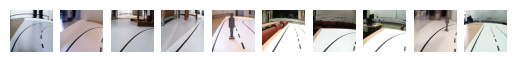

In [52]:
f, axarr = plt.subplots(1,10)

i = 0
for image_batch, label_batch in dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 10:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images

# add data augmentation steps here

# transfer learning here